# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numerapi
from numerapi import NumerAPI

In [ ]:
!pip install torchsort

  Created wheel for torchsort: filename=torchsort-0.1.9-cp37-cp37m-linux_x86_64.whl size=2607659 sha256=c7f48372a008148885722797d2c965821bf4de03a2b5440ef5d37e6dc1809adc
  Stored in directory: /root/.cache/pip/wheels/78/20/69/cc894d3d65cb58f99ada9462cd8fb76e3beaac185efa06df3e
Successfully built torchsort


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import torch
import torchsort
import torch.nn as nn
import torch.optim as optim
from torch.functional import F

import os
import random
import glob
import pathlib
import scipy
import time
import datetime
import gc
from tqdm.auto import tqdm
from sklearn import preprocessing, metrics
from multiprocessing import Pool, cpu_count

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter

sns.set_context("talk")
style.use('seaborn-colorblind')

import warnings
warnings.simplefilter('ignore')

# Check machine spec

In [ ]:
# check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Your runtime has 54.8 gigabytes of available RAM



# Config

In [ ]:
### EDIT THIS CELL ###

DEBUG = False # if True, use sampled trained data (for mob-programming)
EXPERIMENT_NAME = 'FNC_optimize'

OUTPUT_DIR = '/content/drive/MyDrive/ColabNotebooks/NNNS/004_FNCopt'
os.listdir(OUTPUT_DIR)

['nnns-fnc-optimize-train-8c2959.ipynb']

In [ ]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
today = datetime.datetime.now().strftime('%Y-%m-%d')
today

'2022-04-02'

In [ ]:
# Logging is always nice for your experiment:)
def init_logger(log_file='train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = init_logger(log_file=os.path.join(OUTPUT_DIR, f'{today}.log'))
logger.info('Start Logging...')
logger.info(' ### torch edition: {} ###'.format(torch.__version__))

Start Logging...
 ### torch edition: 1.10.0+cu111 ###


# Fetch data

In [ ]:
# setup API
napi = NumerAPI()
current_round = napi.get_current_round(tournament=8)  # tournament 8 is the primary Numerai Tournament
logger.info('NumerAPI is setup!')

NumerAPI is setup!
2022-04-02 13:06:15,385 INFO __main__: NumerAPI is setup!


In [ ]:
if DEBUG: # read pre-stored sampled data
    sample_dir = '../input/numerai-nnns-sampled-data'
    training_data = pd.read_parquet(os.path.join(sample_dir, 'sampled_training_data.parquet'))
    validation_data = pd.read_parquet(os.path.join(sample_dir, 'validation_data.parquet'))
    
    logger.info('Sampled train data and (not sampled) validation data loaded!')
else:
    # read in all of the new datas
    # tournament data and example predictions change every week so we specify the round in their names
    # training and validation data only change periodically, so no need to download them over again every single week
    napi.download_dataset("numerai_training_data_int8.parquet", "numerai_training_data_int8.parquet")
    napi.download_dataset("numerai_validation_data_int8.parquet", f"numerai_validation_data_int8.parquet")
    napi.download_dataset("example_validation_predictions.parquet", "example_validation_predictions.parquet")
    napi.download_dataset("numerai_tournament_data_int8.parquet", f"numerai_tournament_data_int8.parquet")
    napi.download_dataset("example_predictions.parquet", f"example_predictions_{current_round}.parquet")
    
    # load as pd.DataFrame
    training_data = pd.read_parquet('numerai_training_data_int8.parquet')
    validation_data = pd.read_parquet('numerai_validation_data_int8.parquet')
    validation_example_preds = pd.read_parquet('example_validation_predictions.parquet')
    
    # era to int, remove data_type columns
    training_data['era'] = training_data['era'].astype(int)
    validation_data['era'] = validation_data['era'].astype(int)
    training_data.drop(columns=['data_type'], inplace=True)
    validation_data.drop(columns=['data_type'], inplace=True)

    # example pred doesn't exist for training data
    training_data['example_pred'] = np.nan
    validation_data['example_pred'] = validation_example_preds['prediction'].values

    logger.info('Train and validation data loaded from Numerai!')

2022-04-02 13:06:16,398 INFO numerapi.utils: starting download
numerai_training_data_int8.parquet: 1.01GB [01:01, 16.4MB/s]                            
2022-04-02 13:07:19,320 INFO numerapi.utils: starting download
numerai_validation_data_int8.parquet: 228MB [00:16, 14.2MB/s]                           
2022-04-02 13:07:36,304 INFO numerapi.utils: starting download
example_validation_predictions.parquet: 13.0MB [00:01, 7.23MB/s]                            
2022-04-02 13:07:39,059 INFO numerapi.utils: starting download
numerai_tournament_data_int8.parquet: 582MB [00:34, 16.8MB/s]                           
2022-04-02 13:08:14,606 INFO numerapi.utils: starting download
example_predictions_309.parquet: 33.5MB [00:03, 10.2MB/s]                            
Train and validation data loaded from Numerai!
2022-04-02 13:08:24,980 INFO __main__: Train and validation data loaded from Numerai!


In [ ]:
# check data
logger.info('- Training data shape={} (era from {} to {})'.format(
    training_data.shape, training_data['era'].min(), training_data['era'].max()
))
logger.info('- Validation data shape={} (era from {} to {})'.format(
    validation_data.shape, validation_data['era'].min(), validation_data['era'].max()
))

- Training data shape=(2412105, 1073) (era from 1 to 574)
2022-04-02 13:08:24,995 INFO __main__: - Training data shape=(2412105, 1073) (era from 1 to 574)
- Validation data shape=(539658, 1073) (era from 857 to 961)
2022-04-02 13:08:24,999 INFO __main__: - Validation data shape=(539658, 1073) (era from 857 to 961)


In [ ]:
# check features and targets name
features = training_data.columns[training_data.columns.str.startswith('feature')].values.tolist()
targets = training_data.columns[training_data.columns.str.startswith('target')].values.tolist()
logger.info('{} features: {}'.format(len(features), features))
logger.info('{} targets: {}'.format(len(targets), targets))

1050 features: ['feature_dichasial_hammier_spawner', 'feature_rheumy_epistemic_prancer', 'feature_pert_performative_hormuz', 'feature_hillier_unpitied_theobromine', 'feature_perigean_bewitching_thruster', 'feature_renegade_undomestic_milord', 'feature_koranic_rude_corf', 'feature_demisable_expiring_millepede', 'feature_unscheduled_malignant_shingling', 'feature_clawed_unwept_adaptability', 'feature_rubblier_chlorotic_stogy', 'feature_untumbled_histologic_inion', 'feature_piffling_inflamed_jupiter', 'feature_abstersive_emotional_misinterpreter', 'feature_unluckiest_mulley_benzyl', 'feature_escutcheoned_timocratic_kotwal', 'feature_integrated_extroversive_ambivalence', 'feature_vedic_mitral_swiz', 'feature_reclaimed_fallibilist_turpentine', 'feature_gone_honduran_worshipper', 'feature_insociable_exultant_tatum', 'feature_outdated_tapered_speciation', 'feature_leggiest_slaggiest_inez', 'feature_chaldean_vixenly_propylite', 'feature_hysteric_mechanized_recklinghausen', 'feature_glare_facti

# Define model

#### 今日のGoal

#### 今日のTask

#### 実装

#### NNの構造


In [ ]:
# device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info(f'Device: {DEVICE}')

# seed
def seed_torch(seed=46):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(46)

# Define Numerai Dataset   
class NumeraiDataset(torch.utils.data.Dataset):
    """
    https://www.danliden.com/post/mlp-numerai-05082021/
    """
    def __init__(self, df, features, target=None):
        self.df = df
        self.X = df[features].values.astype(np.float32)
        if target is not None:
            self.y = df[target].values.astype(np.float32)
        else:
            self.y = np.ones(len(df))
        self.eras = df['era'].values

    def __len__(self):
        return(len(self.df))

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.eras[idx]

Device: cuda:0
2022-04-02 13:08:25,057 INFO __main__: Device: cuda:0


In [ ]:
import torch
from torch.optim.optimizer import Optimizer
import math


class RAdam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError("RAdam does not support sparse gradients")

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p_data_fp32)
                    state["exp_avg_sq"] = torch.zeros_like(p_data_fp32)
                else:
                    state["exp_avg"] = state["exp_avg"].type_as(p_data_fp32)
                    state["exp_avg_sq"] = state["exp_avg_sq"].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state["step"] += 1
                buffered = self.buffer[int(state["step"] % 10)]
                if state["step"] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state["step"]
                    beta2_t = beta2 ** state["step"]
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state["step"] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = (
                            group["lr"]
                            * math.sqrt(
                                (1 - beta2_t)
                                * (N_sma - 4)
                                / (N_sma_max - 4)
                                * (N_sma - 2)
                                / N_sma
                                * N_sma_max
                                / (N_sma_max - 2)
                            )
                            / (1 - beta1 ** state["step"])
                        )
                    else:
                        step_size = group["lr"] / (1 - beta1 ** state["step"])
                    buffered[2] = step_size

                if group["weight_decay"] != 0:
                    p_data_fp32.add_(-group["weight_decay"] * group["lr"], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group["eps"])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)
        return loss

In [ ]:
# https://forum.numer.ai/t/optimizing-for-fnc-and-tb-scores/5132

TARGET = 'target'

# -----------------------
# hyperparameters
# -----------------------
params = {
    'train_batch_size': 4096,
    'valid_batch_size': 4096,
    'epochs': 30,
    'lr': 1e-03,
    'device': DEVICE
}
    
neut_tb_exp_tl_scale = 1e3
orig_exp_tl_scale = 1e4
# -----------------------
# custom loss
# -----------------------
def numerai_r_tb_exposure(pred, target, features, tb=None, gaussianize=False, regularization_strength=.0001):
    # Computes and returns a Numerai score and feature exposure
    
    pred = pred.reshape(1, -1)
    target = target.reshape(1, -1)
    
    # get sorted indicies
    rr = torchsort.soft_rank(pred, regularization_strength=regularization_strength)
    # change pred to uniform distribution
    pred = (rr - .5)/rr.shape[1]
    
    # convert uniform to gaussian distribution
    if gaussianize:
        pred = torch.distributions.Normal(0,1).icdf(pred)
        
    # select top/bottom indicies
    if tb is not None:
        tbidx = torch.bitwise_xor(rr<=tb, rr > (rr.shape[1]-tb))
        pred = pred[tbidx]
        target = target[tbidx]
        features = features[tbidx[0]]
    
    # Pearson correlation
    pred = pred - pred.mean()
    pred = pred / pred.norm()
    target = target - target.mean()
    target = target / target.norm()
    
    return (pred * target).sum(), ((pred @ features)**2).sum()

def loss_fn(pred, y, features=features):
    # neutralize model output
    b = features.pinverse(rcond=1e-6) @ pred
    linear_pred = features @ b
    neutralized_output = pred - linear_pred

    neut_tb_loss, neut_tb_exp = numerai_r_tb_exposure(neutralized_output, y, features, tb=None)
    orig_loss, orig_exp = numerai_r_tb_exposure(pred, y, features)

    # loss = -tb500 corr for neutralized output - corr for neutralized output - corr + tb500 exposure + exposure
    loss = -neut_tb_loss - orig_loss + neut_tb_exp/neut_tb_exp_tl_scale + orig_exp/orig_exp_tl_scale
    
    return loss

# -----------------------
# metrics
# -----------------------
def calculate_metrics(y_true, y_pred) -> dict:
    """
    calculate metric
    """    
    return {
        'rmse': metrics.mean_squared_error(y_true, y_pred) ** .5,
        'rankcorr': scipy.stats.spearmanr(y_true, y_pred)[0],
    }

# -----------------------
# model
# -----------------------
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(1050, 100)
        self.lin2 = nn.Linear(100, 30)
        self.lin3 = nn.Linear(30, 1)
        self.bn = nn.BatchNorm1d(1)
        self.do1 = nn.Dropout(0.5)
        self.do2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.lin1(x)
        x = self.do1(F.mish(x))
        x = self.lin2(x)
        x = self.do2(F.mish(x))
        output = self.bn(self.lin3(x))
        return output
    
# -----------------------
# training
# -----------------------
# train       
def train(train_loader, model, optimizer, device):
    """
    train for one epoch
    :param train_loader: the pytorch dataloader (training data)
    :param model: pytorch model
    :param optimizer: optimizer (e.g., adam, sgd...)
    :param device: cuda/cpu
    """

    # train mode
    model.train()

    # go over every batch of data in data loader
    train_loss = 0
    for batch_i, (inputs, targets, eras) in enumerate(train_loader):
        
        # move inputs and targets to device
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        # zero grad the optimizer
        optimizer.zero_grad()
        
        # forward step
        outputs = model(inputs)

        # calculate loss
        loss = loss_fn(outputs, targets, inputs)
        
        # backward step the loss
        loss.backward()
        train_loss += loss.item() / len(targets)

        # step optimizer
        optimizer.step()
        
    return train_loss

def predict(data_loader, model, device):
    """
    predict by trained model
    :parm data_loader: the pytorch dataloader
    :param model: pytorch model
    :param device: cuda/cpu
    """

    # evaludation mode
    model.eval()

    # predicts
    predicts = []

    # no_grad context is used
    with torch.no_grad():
        for batch_i, (inputs, _, _) in enumerate(data_loader):
            inputs = inputs.to(device, dtype=torch.float)

            # forward step to get prediction
            output = model(inputs)

            # convert outputs to lists
            output = output.detach().cpu().numpy().tolist()
            
            # extend the list
            predicts.extend(output)

    # return final output
    pred = np.array(predicts).reshape(-1)
    return pred

def run_fold(
    model
    , training_data
    , validation_data=None
    , features=['feature_dichasial_hammier_spawner', 'feature_rheumy_epistemic_prancer']
    , target='target'
    , fold_id='seed46_fold3'
    , params=params
    ) -> np.ndarray:
    """
    run train / valid for one fold
    """
    
    # optimizer
    optimizer = RAdam(params=model.parameters(), lr=params['lr'])

    # scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['epochs']-1)
    
    for epoch in range(1, params['epochs']+1):
        print(f'start epoch : {epoch}')
        # -------------------------
        # data loader
        # -------------------------
        # train
        
        train_dataset = NumeraiDataset(training_data, features, target)
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=params['train_batch_size'], shuffle=True
        )
        

        # valid
        if validation_data is not None:
            valid_dataset = NumeraiDataset(validation_data, features, target)
            valid_loader = torch.utils.data.DataLoader(
                valid_dataset, batch_size=params['valid_batch_size'], shuffle=False
            )

        # -------------------------
        # fit
        # -------------------------
        # train
        train_loss = train(train_loader, model, optimizer, params['device'])
        scheduler.step()
        print(scheduler.get_last_lr())

        # -------------------------
        # inference
        # -------------------------
        # predict on valid
        if validation_data is not None:
            pred = predict(valid_loader, model, params['device'])
            scores = calculate_metrics(validation_data[target].values, pred)

            print(f'EPOCH {epoch}...TRAIN LOSS: {train_loss:.4f}:')
            print(f'===> validation score: {scores}')

        # save model weight
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f'model_{fold_id}.pth'))
        
model = Net()
model

Net(
  (lin1): Linear(in_features=1050, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=30, bias=True)
  (lin3): Linear(in_features=30, out_features=1, bias=True)
  (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do1): Dropout(p=0.5, inplace=False)
  (do2): Dropout(p=0.5, inplace=False)
)

# Training

In [ ]:
# utils

def get_time_series_cross_val_splits(data, cv=3, embargo=4, era_col='era'):
    """Numerai data splitter for cross validation
    use embargo = 12 when use target_XXX_60 to avoid potential leakage (target days / 5)
    
    https://github.com/numerai/example-scripts/blob/master/utils.py
    """
    all_train_eras = data[era_col].unique()
    len_split = len(all_train_eras) // cv
    test_splits = [all_train_eras[i * len_split:(i + 1) * len_split] for i in range(cv)]
    # fix the last test split to have all the last eras, in case the number of eras wasn't divisible by cv
    test_splits[-1] = np.append(test_splits[-1], all_train_eras[-1])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the eras that aren't in the test split
        train_split_not_embargoed = [e for e in all_train_eras if not (test_split_min <= int(e) <= test_split_max)]
        # embargo the train split so we have no leakage.
        # one era is length 5, so we need to embargo by target_length/5 eras.
        # To be consistent for all targets, let's embargo everything by 60/5 == 12 eras.
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo and abs(int(e) - test_split_min) > embargo]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

def run_folds(
    training_data
    , validation_data
    , features
    , target='target'
    , params=params
    , cv=3
    , embargo=4
    , seed=42
    ):
    """
    run folds
    """
    # test dataloader
    validation_ds = NumeraiDataset(validation_data, features, target)
    validation_loader = torch.utils.data.DataLoader(
        validation_ds, batch_size=params['valid_batch_size'], shuffle=False
    )
    
    # train valid split
    train_test_zip = get_time_series_cross_val_splits(
        training_data, cv=cv, embargo=embargo, era_col='era'
    )
    
    # initialize pred column
    validation_data[f'pred_target_seed{seed}'] = 0
    
    # fit with CV
    for fold_id, train_test_split in enumerate(train_test_zip):
        # train test split
        print(f"doing split {fold_id+1} out of {cv}")
        train_split, val_split = train_test_split
        
        # create model
        seed_torch(seed)
        model = Net()
        model.to(params['device'])

        # run fold
        run_fold(
            model
            , training_data.loc[training_data['era'].isin(train_split)]
            , training_data.loc[training_data['era'].isin(val_split)]
            , features=features
            , target=target
            , fold_id=f'seed{seed}_fold{fold_id}'
            , params=params
        )
        
        # load trained model        
        model = Net()
        model.to(params['device'])
        model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, f'model_seed{seed}_fold{fold_id}.pth')))
        
        # predict on test
        pred = predict(validation_loader, model, params['device'])
        validation_data[f'pred_target_seed{seed}'] += np.array(pred) / cv
        del model

    return validation_data

In [ ]:
### EDIT THIS CELL, if necessary ###

# training config
NUM_SEEDS = 5
CV = 4
EMBARGO = 4
    
# fit with cross validation with different seeds
seeds = [42 + s for s in range(NUM_SEEDS)]
for seed in tqdm(seeds):
    print('')
    print(f'Current seed = {seed}')
    print('')
    
    # fit with cv
    validation_data = run_folds(
        training_data
        , validation_data
        , features
        , target=TARGET
        , params=params
        , cv=CV
        , embargo=EMBARGO
        , seed=seed
        )
    
# seed average
pred_cols = [f for f in validation_data.columns if 'pred_' in f]
validation_data[f'pred_{TARGET}_seed_average'] = validation_data[pred_cols].values.mean(axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]


Current seed = 42

doing split 1 out of 4
start epoch : 1
[0.0009970689785771798]
EPOCH 1...TRAIN LOSS: 0.0694:
===> validation score: {'rmse': 0.6331569004820439, 'rankcorr': 0.00026903315310813566}
start epoch : 2
[0.0009883102778550433]
EPOCH 2...TRAIN LOSS: 0.0417:
===> validation score: {'rmse': 0.43267898672749466, 'rankcorr': 0.008163683330996582}
start epoch : 3
[0.0009738265855914012]
EPOCH 3...TRAIN LOSS: 0.0479:
===> validation score: {'rmse': 0.47130827053478513, 'rankcorr': 0.002782550059600544}
start epoch : 4
[0.0009537877098354786]
EPOCH 4...TRAIN LOSS: 0.0436:
===> validation score: {'rmse': 0.5088200555332297, 'rankcorr': -0.003310197206239494}
start epoch : 5
[0.0009284285880837947]
EPOCH 5...TRAIN LOSS: 0.0526:
===> validation score: {'rmse': 0.5349201273628114, 'rankcorr': -0.008370073104364354}
start epoch : 6
[0.000898046532852822]
EPOCH 6...TRAIN LOSS: 0.0429:
===> validation score: {'rmse': 0.48417652710611536, 'rankcorr': -0.002549415691166772}
start epoch : 

# Validation score

In [ ]:
# https://github.com/numerai/example-scripts/blob/master/utils.py
def neutralize(df,
               columns,
               neutralizers=None,
               proportion=1.0,
               normalize=True,
               era_col="era"):
    if neutralizers is None:
        neutralizers = []
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        df_era = df[df[era_col] == u]
        scores = df_era[columns].values
        if normalize:
            scores2 = []
            for x in scores.T:
                x = (scipy.stats.rankdata(x, method='ordinal') - .5) / len(x)
                x = scipy.stats.norm.ppf(x)
                scores2.append(x)
            scores = np.array(scores2).T
        exposures = df_era[neutralizers].values

        scores -= proportion * exposures.dot(
            np.linalg.pinv(exposures.astype(np.float32)).dot(scores.astype(np.float32)))

        scores /= scores.std(ddof=0)

        computed.append(scores)

    return pd.DataFrame(np.concatenate(computed),
                        columns=columns,
                        index=df.index)

def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)

    # this line makes series neutral to a constant column so that it's centered and for sure gets corr 0 with exposures
    exposures = np.hstack(
        (exposures,
         np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))

    correction = proportion * (exposures.dot(
        np.linalg.lstsq(exposures, scores, rcond=None)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized


def unif(df):
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)


def get_feature_neutral_mean(df, prediction_col, ERA_COL='era', TARGET_COL='target'):
    """Compute FNC (std, sharpe added)
    """
    feature_cols = [c for c in df.columns if c.startswith("feature")]
    df.loc[:, "neutral_sub"] = neutralize(df, [prediction_col],
                                          feature_cols)[prediction_col]
    scores = df.groupby(ERA_COL).apply(
        lambda x: (unif(x["neutral_sub"]).corr(x[TARGET_COL])))
    fnc = scores.mean()
    fnc_std = scores.std()
    fnc_sharpe = fnc / fnc_std
    return fnc, fnc_std, fnc_sharpe


def fast_score_by_date(df, columns, target, tb=None, era_col="era"):
    unique_eras = df[era_col].unique()
    computed = []
    for u in unique_eras:
        df_era = df[df[era_col] == u]
        era_pred = np.float64(df_era[columns].values.T)
        era_target = np.float64(df_era[target].values.T)

        if tb is None:
            ccs = np.corrcoef(era_target, era_pred)[0, 1:]
        else:
            tbidx = np.argsort(era_pred, axis=1)
            tbidx = np.concatenate([tbidx[:, :tb], tbidx[:, -tb:]], axis=1)
            ccs = [np.corrcoef(era_target[tmpidx], tmppred[tmpidx])[0, 1] for tmpidx, tmppred in zip(tbidx, era_pred)]
            ccs = np.array(ccs)

        computed.append(ccs)

    return pd.DataFrame(np.array(computed), columns=columns, index=df[era_col].unique())

def calculate_fnc(sub, targets, features):
    """    
    https://jp.docs.numer.ai/numerai-tnamento/feature-neutral-correlation
    Args:
        sub (pd.Series)
        targets (pd.Series)
        features (pd.DataFrame)
    """

    # Normalize submission
    sub = (sub.rank(method="first").values - 0.5) / len(sub)

    # Neutralize submission to features
    f = features.values
    sub -= f.dot(np.linalg.pinv(f).dot(sub))
    sub /= sub.std()

    sub = pd.Series(np.squeeze(sub)) # Convert np.ndarray to pd.Series

    # FNC: Spearman rank-order correlation of neutralized submission to target
    fnc = np.corrcoef(sub.rank(pct=True, method="first"), targets)[0, 1]

    return fnc

def validation_metrics_per_pred(pred_col, validation_data=validation_data, example_col='example_pred', fast_mode=False, ERA_COL='era', TARGET_COL='target'):
    validation_stats = pd.DataFrame()
    feature_cols = [c for c in validation_data if c.startswith("feature_")]
    
    # Check the per-era correlations on the validation set (out of sample)
    validation_correlations = validation_data.groupby(ERA_COL).apply(
        lambda d: unif(d[pred_col]).corr(d[TARGET_COL]))

    mean = validation_correlations.mean()
    std = validation_correlations.std(ddof=0)
    sharpe = mean / std

    validation_stats.loc["mean", pred_col] = mean
    validation_stats.loc["std", pred_col] = std
    validation_stats.loc["sharpe", pred_col] = sharpe

    rolling_max = (validation_correlations + 1).cumprod().rolling(window=9000,  # arbitrarily large
                                                                  min_periods=1).max()
    daily_value = (validation_correlations + 1).cumprod()
    max_drawdown = -((rolling_max - daily_value) / rolling_max).max()
    validation_stats.loc["max_drawdown", pred_col] = max_drawdown

    payout_scores = validation_correlations.clip(-0.25, 0.25)
    payout_daily_value = (payout_scores + 1).cumprod()

    apy = (
        (
            (payout_daily_value.dropna().iloc[-1])
            ** (1 / len(payout_scores))
        )
        ** 49  # 52 weeks of compounding minus 3 for stake compounding lag
        - 1
    ) * 100

    validation_stats.loc["apy", pred_col] = apy

    if not fast_mode:
        # Check the feature exposure of your validation predictions
        max_per_era = validation_data.groupby(ERA_COL).apply(
            lambda d: d[feature_cols].corrwith(d[pred_col]).abs().max())
        max_feature_exposure = max_per_era.mean()
        validation_stats.loc["max_feature_exposure", pred_col] = max_feature_exposure

        # Check feature neutral mean
        fnc, fnc_std, fnc_sharpe = get_feature_neutral_mean(validation_data, pred_col)
        validation_stats.loc["fnc", pred_col] = fnc
        validation_stats.loc["fnc_std", pred_col] = fnc_std
        validation_stats.loc["fnc_sharpe", pred_col] = fnc_sharpe

        # Check top and bottom 200 metrics (TB200)
        tb200_validation_correlations = fast_score_by_date(
            validation_data,
            [pred_col],
            TARGET_COL,
            tb=200,
            era_col=ERA_COL
        )

        # Check top and bottom 200 metrics (TB200)
        tb200_mean = tb200_validation_correlations.mean()[pred_col]
        tb200_std = tb200_validation_correlations.std(ddof=0)[pred_col]
        tb200_sharpe = mean / std

        validation_stats.loc["tb200_mean", pred_col] = tb200_mean
        validation_stats.loc["tb200_std", pred_col] = tb200_std
        validation_stats.loc["tb200_sharpe", pred_col] = tb200_sharpe

    # MMC over validation
    mmc_scores = []
    corr_scores = []
    for _, x in validation_data.groupby(ERA_COL):
        series = neutralize_series(unif(x[pred_col]), (x[example_col]))
        mmc_scores.append(np.cov(series, x[TARGET_COL])[0, 1] / (0.29 ** 2))
        corr_scores.append(unif(x[pred_col]).corr(x[TARGET_COL]))

    val_mmc_mean = np.mean(mmc_scores)
    val_mmc_std = np.std(mmc_scores)
    corr_plus_mmcs = [c + m for c, m in zip(corr_scores, mmc_scores)]
    corr_plus_mmc_sharpe = np.mean(corr_plus_mmcs) / np.std(corr_plus_mmcs)

    validation_stats.loc["mmc_mean", pred_col] = val_mmc_mean
    validation_stats.loc["corr_plus_mmc_sharpe", pred_col] = corr_plus_mmc_sharpe

    # Check correlation with example predictions
    per_era_corrs = validation_data.groupby(ERA_COL).apply(lambda d: unif(d[pred_col]).corr(unif(d[example_col])))
    corr_with_example_preds = per_era_corrs.mean()
    validation_stats.loc["corr_with_example_preds", pred_col] = corr_with_example_preds
    return validation_stats

def validation_metrics(pred_cols):
    """Multiprocessing added
    """
    with Pool(cpu_count()) as p:
        validation_stats = list(tqdm(p.imap(validation_metrics_per_pred, pred_cols), total=len(pred_cols)))
    validation_stats = pd.concat(validation_stats, axis=1)
    
    # .transpose so that stats are columns and the model_name is the row
    return validation_stats.transpose()

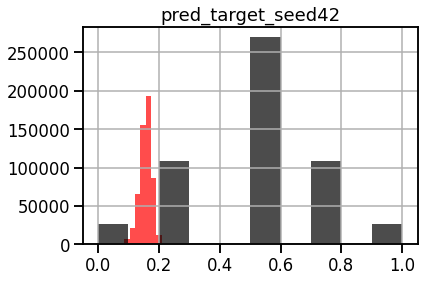

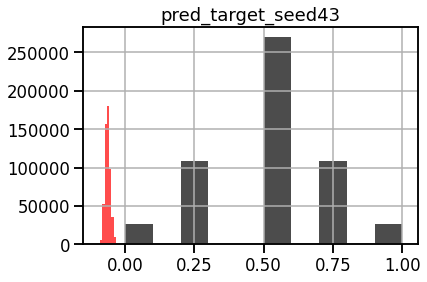

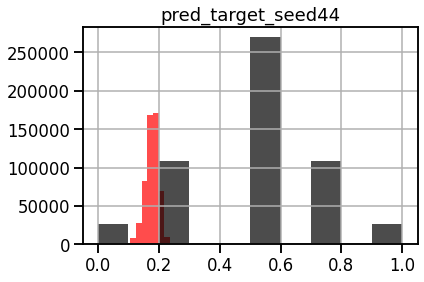

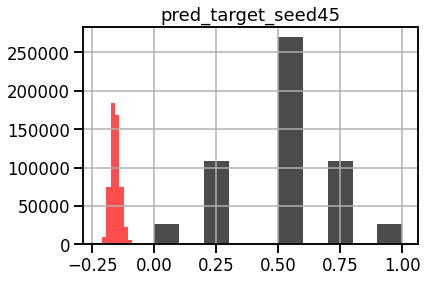

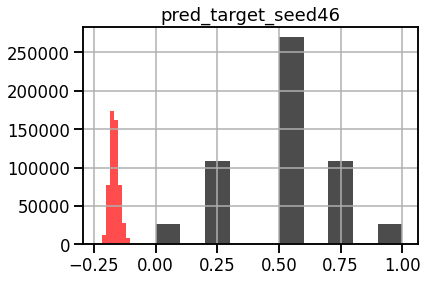

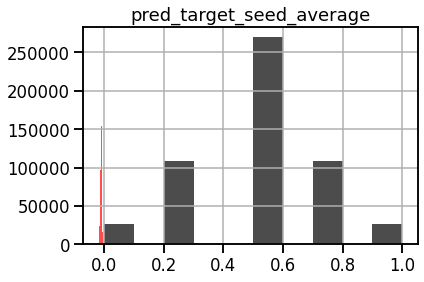

In [ ]:
# plot hists of target and prediction
pred_cols = [f for f in validation_data.columns if 'pred_' in f]
for pred_col in pred_cols:
    validation_data[pred_col].hist(color='r', alpha=0.7, label='prediction')
    validation_data[TARGET].hist(color='k', alpha=0.7, label='target')
    plt.title(pred_col)
    plt.show()

In [ ]:
%%time

# scoring
val_scores = validation_metrics(pred_cols)
val_scores.style.background_gradient(cmap='OrRd', axis=0)

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 3.21 s, sys: 1.88 s, total: 5.09 s
Wall time: 14min 49s


In [ ]:
val_scores

ALL DONE!